In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import GPy
import gp_cv_helpers
from pandas import Series, DataFrame
from sklearn import cross_validation
from IPython.core.pylabtools import figsize

%matplotlib inline
figsize(16, 8)
ALLOWED_ERROR = 1.5

In [2]:
df_std1 = pd.read_csv('../../data/std1_mh_11_pubchem_hmdb.csv', keep_default_na=False)
df_std2 = pd.read_csv('../../data/std2_mh_11_pubchem_hmdb.csv', keep_default_na=False)

# Removed heavy molecules
df_std1 = df_std1[df_std1['EXACT_MASS'] <= 280]
df_std2 = df_std2[df_std2['EXACT_MASS'] <= 280]

df_std1.drop(0, axis=0, inplace=True)
df_std1['JCHEM_ACIDIC_PKA'] = df_std1['JCHEM_ACIDIC_PKA'].astype(float)

for df in [df_std1, df_std2]:
    max_intensity = df['Dil_1_1'].max()
    df['Dil_1_1'] = df['Dil_1_1'] / max_intensity
    df['Dil_1_1'] = np.log(df['Dil_1_1'])

df_merged = pd.concat([df_std1, df_std2])
df_merged.reset_index(inplace=True)

EXT_X_train, EXT_X_test, EXT_y_train, EXT_y_test = cross_validation.train_test_split(
    df_merged, df_merged[['Dil_1_1']], test_size=0.25, random_state=3)

# PCA

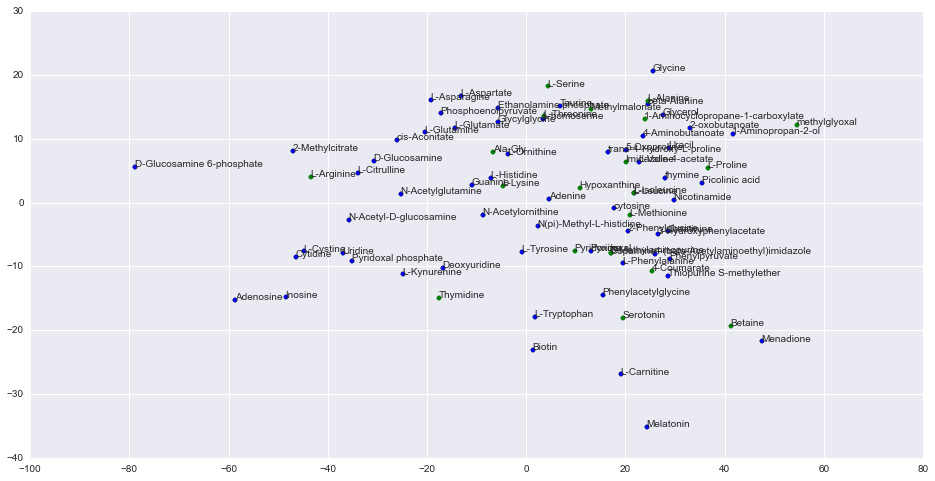

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, whiten=False)

pca.fit(EXT_X_train[gp_cv_helpers.features])

X_train_tr = pca.transform(EXT_X_train[gp_cv_helpers.features])
X_test_tr = pca.transform(EXT_X_test[gp_cv_helpers.features])
X_all_tr = pca.transform(df_merged[gp_cv_helpers.features])

fig, ax = plt.subplots()

plt.scatter(X_train_tr[:, 0], X_train_tr[:, 1])
plt.scatter(X_test_tr[:, 0], X_test_tr[:, 1], color='g')

for x, y, label in zip(X_all_tr[:, 0], X_all_tr[:, 1], df_merged['Name']):
    ann = ax.annotate(label, (x, y))

plt.grid(True)
plt.show()

# Cross Validation

In [4]:
N_FOLDS = 5

arr_lengthscale = np.linspace(100, 200, num=50)
arr_variance = np.linspace(10e6, 30e6, num=50)

df_results = gp_cv_helpers.cross_validation_scoring(EXT_X_train[gp_cv_helpers.features], EXT_y_train, arr_lengthscale, arr_variance, n_folds=N_FOLDS)
df_grid_scores = gp_cv_helpers.calculate_scores(df_results, N_FOLDS)

Training on Fold 1/5
Training on Fold 1/5 Completed - 0:00:19.998750
Training on Fold 2/5
Training on Fold 2/5 Completed - 0:00:19.297070
Training on Fold 3/5
Training on Fold 3/5 Completed - 0:00:19.201811
Training on Fold 4/5
Training on Fold 4/5 Completed - 0:00:19.557189
Training on Fold 5/5
Training on Fold 5/5 Completed - 0:00:19.254037


# Best parameters based on predictive likelihood

In [5]:
p_mll = df_grid_scores[df_grid_scores['avg_mll'] == df_grid_scores['avg_mll'].max()]
p_mll

,ls,var,avg_r2,avg_mse,avg_mll
2196,187.755102,28775510.204082,-0.700244,12.170431,-30.918769


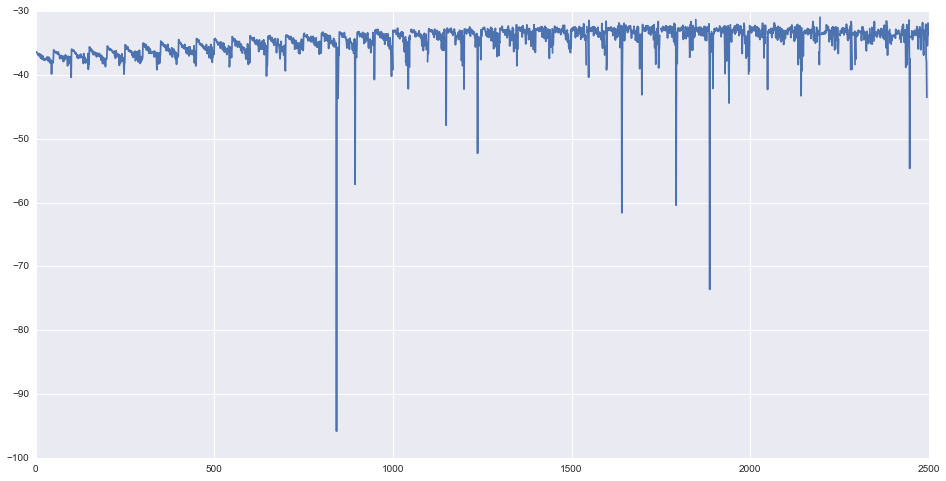

In [6]:
plt.plot(df_grid_scores.index, df_grid_scores['avg_mll'])
plt.show()

# Validation Plot & Training Plot

Validating on holdout data

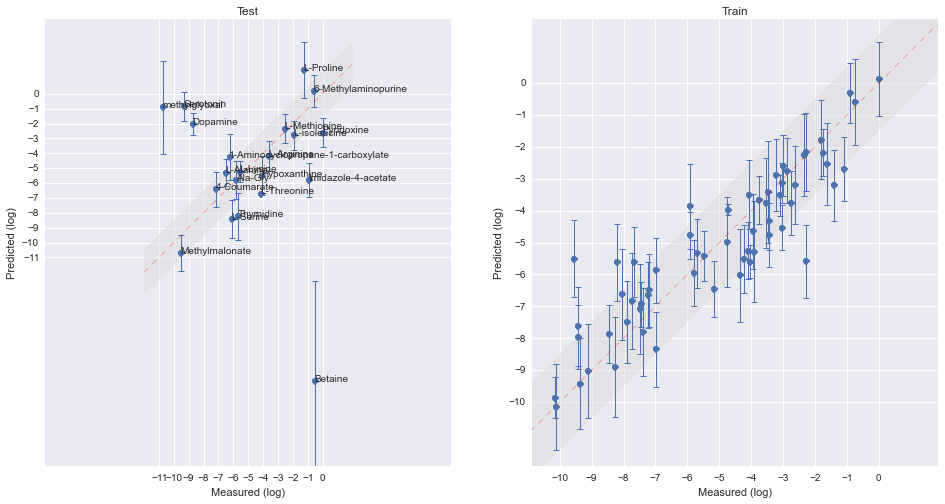

In [7]:
ls = p_mll['ls']
var = p_mll['var']

plt.subplot(1, 2, 1)
mu_, s_ = gp_cv_helpers.predict(EXT_X_train[gp_cv_helpers.features], EXT_y_train, EXT_X_test[gp_cv_helpers.features], ls, var)
gp_cv_helpers.plot_results(EXT_y_test['Dil_1_1'], mu_, s_, title='Test', allowed_error=ALLOWED_ERROR, labels=EXT_X_test['Name'])

plt.subplot(1, 2, 2)
mu_train, s_train = gp_cv_helpers.predict(EXT_X_train[gp_cv_helpers.features], EXT_y_train, EXT_X_train[gp_cv_helpers.features], ls, var)
gp_cv_helpers.plot_results(EXT_y_train['Dil_1_1'], mu_train, s_train, title='Train', allowed_error=ALLOWED_ERROR)

# Detailed Validation Plot

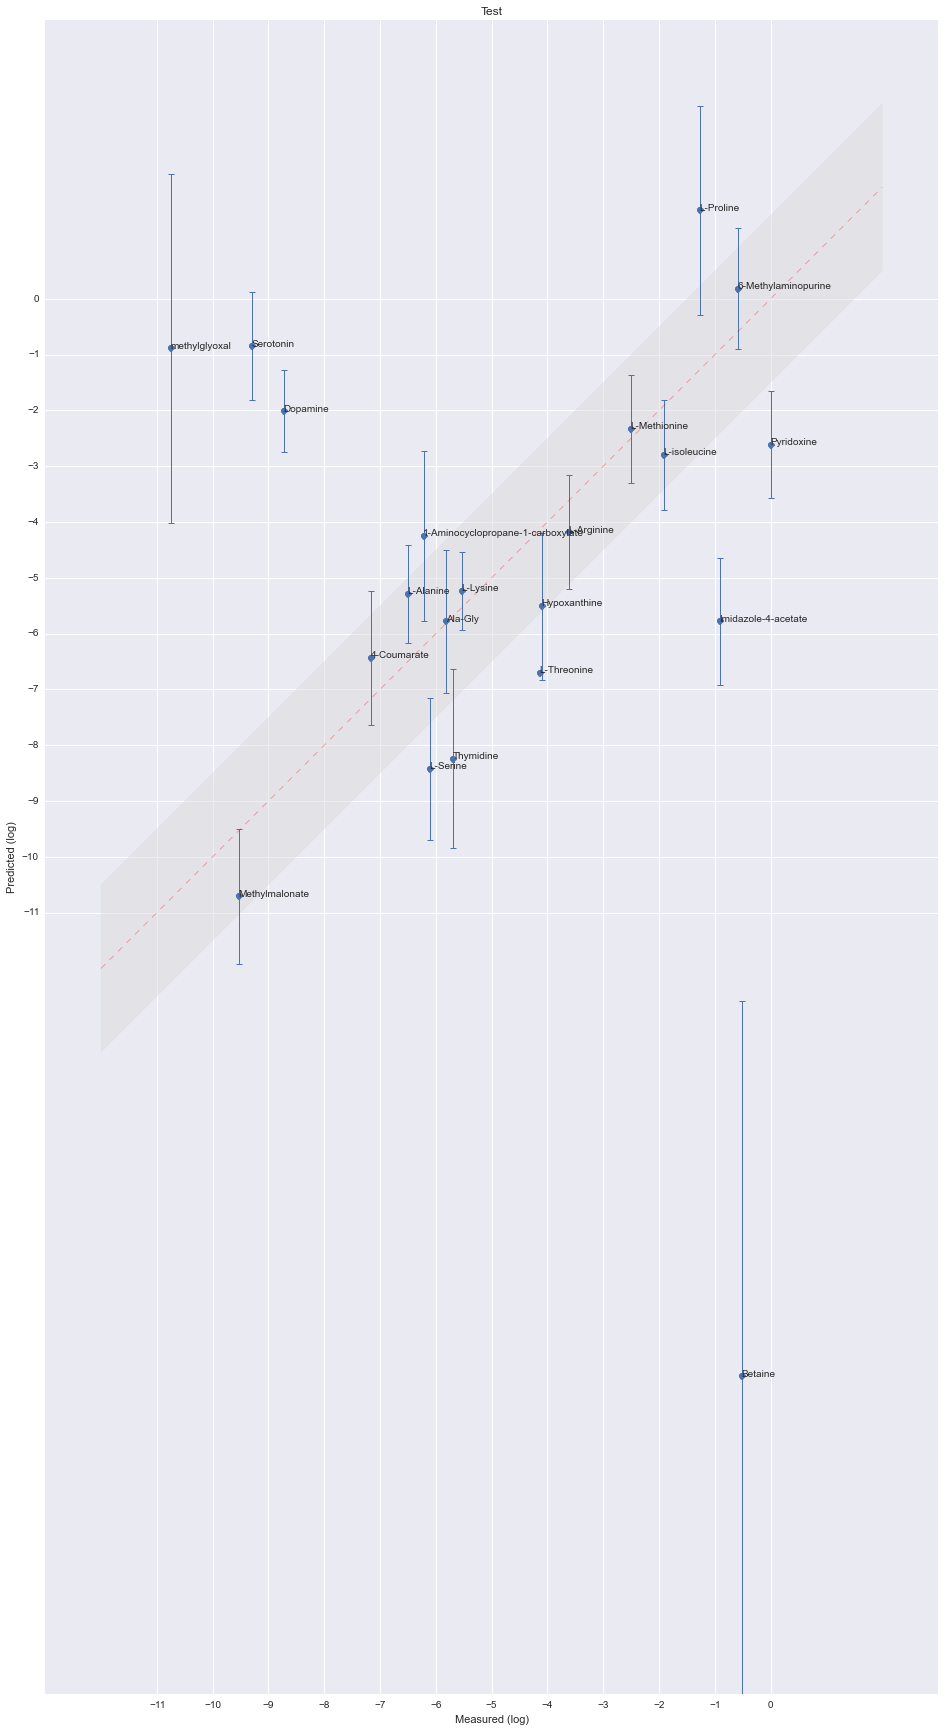

In [8]:
plt.figure(figsize=(16, 30))
mu_, s_ = gp_cv_helpers.predict(EXT_X_train[gp_cv_helpers.features], EXT_y_train, EXT_X_test[gp_cv_helpers.features], ls, var)
gp_cv_helpers.plot_results(EXT_y_test['Dil_1_1'], mu_, s_, title='Test', allowed_error=ALLOWED_ERROR, labels=EXT_X_test['Name'])
plt.show()

# Listing good and bad predictions

Based on absolute distance of the mean from the true value

In [9]:
mu_abs_diff = np.abs(EXT_y_test['Dil_1_1'] - Series(mu_.ravel(), index=EXT_y_test.index))

outside = (mu_abs_diff > ALLOWED_ERROR)

# Within Error Range

In [10]:
EXT_X_test.ix[~outside][['Name', 'Formula', 'MOLECULAR_WEIGHT'] + gp_cv_helpers.features]

,Name,Formula,MOLECULAR_WEIGHT,JCHEM_ACIDIC_PKA,JCHEM_LOGP,JCHEM_POLARIZABILITY,JCHEM_POLAR_SURFACE_AREA,JCHEM_REFRACTIVITY
6,L-Methionine,C5H11NO2S,149.2110,2.53,-2.200,15.50,63.32,37.59
32,L-Arginine,C6H14N4O2,174.2010,2.41,-3.200,17.92,127.72,43.63
68,Ala-Gly,C5H10N2O3,146.1445,3.66,-3.900,13.83,92.42,33.30
47,Hypoxanthine,C5H4N4O,136.1115,8.72,-0.048,11.82,74.69,35.50
62,L-Alanine,C3H7NO2,89.0932,2.47,-2.800,8.54,63.32,20.50
52,6-Methylaminopurine,C6H7N5,149.1533,10.24,-0.270,14.43,66.49,43.71
53,L-isoleucine,C6H13NO2,131.1729,2.79,-1.500,14.27,63.32,34.09
34,4-Coumarate,C9H8O3,164.1580,4.00,1.830,16.43,57.53,45.04
35,Methylmalonate,C4H6O4,118.0880,2.48,0.210,10.06,74.60,23.56
31,L-Lysine,C6H14N2O2,146.1876,2.74,-3.200,16.01,89.34,37.81


# Outside the range

In [11]:
EXT_X_test.ix[outside][['Name', 'Formula', 'MOLECULAR_WEIGHT'] + gp_cv_helpers.features]

,Name,Formula,MOLECULAR_WEIGHT,JCHEM_ACIDIC_PKA,JCHEM_LOGP,JCHEM_POLARIZABILITY,JCHEM_POLAR_SURFACE_AREA,JCHEM_REFRACTIVITY
12,L-Proline,C5H9NO2,115.1305,1.94,-2.60,11.53,49.33,28.06
17,L-Threonine,C4H9NO3,119.1192,2.21,-3.50,11.25,83.55,26.46
36,Thymidine,C10H14N2O5,242.2286,9.96,-1.10,23.06,99.10,55.41
74,Dopamine,C8H11NO2,153.1784,10.01,0.03,16.21,66.48,43.25
9,Imidazole-4-acetate,C5H6N2O2,126.1133,3.65,-1.40,11.47,65.98,30.20
8,Pyridoxine,C8H11NO3,169.1778,9.40,-0.95,17.11,73.58,44.11
45,methylglyoxal,C3H4O2,72.0627,16.38,0.20,6.44,34.14,17.05
23,L-Serine,C3H7NO3,105.0926,2.03,-3.90,9.45,83.55,22.04
57,Betaine,C5H11NO2,117.1463,2.26,-4.50,12.11,40.13,52.82
13,Serotonin,C10H12N2O,176.2151,9.31,0.48,19.31,62.04,52.35


# PCA Plot showing the bad predictions

In [12]:
names = EXT_X_test.ix[outside]['Name']

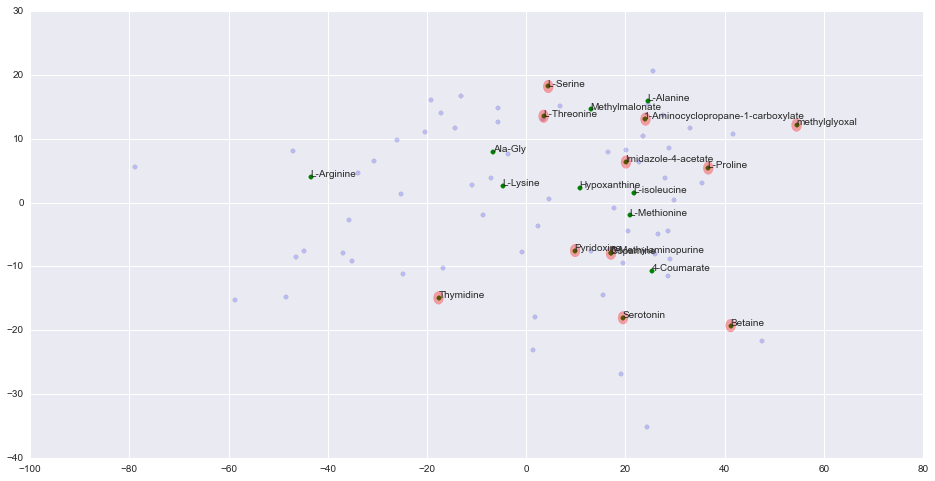

In [13]:
fig, ax = plt.subplots()

plt.scatter(X_train_tr[:, 0], X_train_tr[:, 1], alpha=0.2)
plt.scatter(X_test_tr[:, 0], X_test_tr[:, 1], color='g')

for x, y, label in zip(X_test_tr[:, 0], X_test_tr[:, 1], EXT_X_test['Name']):
    ann = ax.annotate(label, (x, y))
    if label in names.values:
        c = plt.Circle((x, y), 1, color='red', fill=True, alpha=0.33)
        fig.gca().add_artist(c)

plt.grid(True)
plt.show()